In [1]:
import os
import shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import yaml


In [2]:
def create_folder_structure(base_path):
    folders = [
        'data/train/images', 'data/train/labels',
        'data/val/images', 'data/val/labels',
        'data/test/images', 'data/test/labels'
    ]
    for folder in folders:
        os.makedirs(os.path.join(base_path, folder), exist_ok=True)

def convert_bbox(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    return (x * dw, y * dh, w * dw, h * dh)

def convert_annotation(xml_path, output_path, classes):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    with open(output_path, 'w') as out_file:
        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in classes or int(difficult) == 1:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('ymin').text),
                 float(xmlbox.find('xmax').text), float(xmlbox.find('ymax').text))
            bb = convert_bbox((w, h), b)
            out_file.write(f"{cls_id} {' '.join(map(str, bb))}\n")

def process_images(image_files, image_folder, annotation_folder, output_path, split, classes):
    for file in image_files:
        # Image
        src_img = os.path.join(image_folder, file)
        dst_img = os.path.join(output_path, f'data/{split}/images', file)
        shutil.copy(src_img, dst_img)

        # Annotation
        xml_file = os.path.splitext(file)[0] + '.xml'
        src_xml = os.path.join(annotation_folder, xml_file)
        dst_txt = os.path.join(output_path, f'data/{split}/labels', os.path.splitext(file)[0] + '.txt')
        convert_annotation(src_xml, dst_txt, classes)

def split_and_process_dataset(image_files, image_folder, annotation_folder, output_path, classes):
    train_val, test = train_test_split(image_files, test_size=0.2, random_state=42)
    train, val = train_test_split(train_val, test_size=0.2, random_state=42)

    for split, files in [('train', train), ('val', val), ('test', test)]:
        process_images(files, image_folder, annotation_folder, output_path, split, classes)
def create_yaml(output_path, classes):
    yaml_content = {
        'train': f'{HOME}/data/train/images',
        'val': f'{HOME}/data/val/images',
        'test': f'{HOME}/data/test/images',
        'nc': len(classes),
        'names': classes
    }

    with open(os.path.join(output_path, 'data', 'data.yaml'), 'w') as yaml_file:
        yaml.dump(yaml_content, yaml_file, default_flow_style=False)        

In [3]:

if __name__ == "__main__":
    HOME = os.getcwd()
    print(HOME)
    
    create_folder_structure(HOME)

    dataset_path = '/kaggle/input/face-mask-detection'
    output_path = f'{HOME}/'
    classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']
    
    image_folder = os.path.join(dataset_path, 'images')
    annotation_folder = os.path.join(dataset_path, 'annotations')
    
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
    
    split_and_process_dataset(image_files, image_folder, annotation_folder, output_path, classes)
    create_yaml(output_path, classes)

/kaggle/working


In [4]:
!pip install -U ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 591.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.3/872.3 kB 5.7 MB/s eta 0:00:0000:0100:01


In [7]:
from ultralytics import YOLO
model = YOLO('yolov8s.pt')  

# Train the model
res = model.train(
    data='/kaggle/working/data/data.yaml',
    epochs=50,     # Set the number of epochs 
    batch=32,       # Set the batch size to 32
    plots=True,   
    imgsz=640,
    )

100%|██████████| 21.5M/21.5M [00:00<00:00, 165MB/s] 


Ultralytics YOLOv8.2.85 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/data/data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

100%|██████████| 755k/755k [00:00<00:00, 14.0MB/s]
2024-09-01 16:01:35,298	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-01 16:01:36,624	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 72.2MB/s]


AMP: checks passed ✅


/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /kaggle/working/data/train/labels... 545 images, 0 backgrounds, 0 corrupt: 100%|██████████| 545/545 [00:01<00:00, 463.56it/s]

train: New cache created: /kaggle/working/data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data/val/labels... 137 images, 0 backgrounds, 0 corrupt: 100%|██████████| 137/137 [00:00<00:00, 458.22it/s]


val: New cache created: /kaggle/working/data/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      8.61G      2.042      2.956      1.705          7        640: 100%|██████████| 18/18 [00:12<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        137        570      0.387      0.463      0.443      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.75G      1.254      1.163      1.124          3        640: 100%|██████████| 18/18 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all        137        570      0.466      0.508      0.502      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.26G      1.198     0.9016      1.085          7        640: 100%|██████████| 18/18 [00:08<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all        137        570      0.453      0.455      0.427      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.99G      1.179     0.7896      1.049         10        640: 100%|██████████| 18/18 [00:08<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all        137        570      0.558      0.583      0.565      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.92G      1.178     0.7842      1.048          5        640: 100%|██████████| 18/18 [00:08<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all        137        570      0.564      0.667      0.548      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.47G      1.138     0.7417      1.038          4        640: 100%|██████████| 18/18 [00:08<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all        137        570      0.629      0.499      0.532      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.95G      1.119      0.737      1.061          9        640: 100%|██████████| 18/18 [00:08<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all        137        570      0.642      0.604      0.661      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.54G      1.082     0.7399      1.041          1        640: 100%|██████████| 18/18 [00:08<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all        137        570      0.569      0.702      0.661       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.24G      1.161     0.7258      1.021         20        640: 100%|██████████| 18/18 [00:08<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all        137        570      0.804      0.732      0.777      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.32G      1.103     0.6893      1.026          3        640: 100%|██████████| 18/18 [00:08<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all        137        570      0.906      0.773      0.851      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.06G      1.056     0.6579      1.024          1        640: 100%|██████████| 18/18 [00:08<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all        137        570      0.713      0.653      0.675      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.18G      1.044       0.64      1.004          9        640: 100%|██████████| 18/18 [00:08<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all        137        570      0.701      0.701       0.72      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.67G      1.079     0.6523      1.013          5        640: 100%|██████████| 18/18 [00:08<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all        137        570      0.815      0.759       0.83      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.17G       1.09     0.6702      1.005         10        640: 100%|██████████| 18/18 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all        137        570       0.94      0.768      0.852      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.05G      1.035     0.5967     0.9888         10        640: 100%|██████████| 18/18 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all        137        570      0.816      0.814      0.847      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.93G     0.9771     0.5892     0.9758          1        640: 100%|██████████| 18/18 [00:08<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all        137        570      0.857      0.721      0.799      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.57G      1.004     0.6028     0.9954          3        640: 100%|██████████| 18/18 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all        137        570      0.929      0.789      0.881      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.43G      1.017     0.6015     0.9871          1        640: 100%|██████████| 18/18 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all        137        570      0.936      0.758      0.878       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.47G      1.004     0.5678     0.9838          3        640: 100%|██████████| 18/18 [00:08<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all        137        570      0.876      0.821      0.889      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.19G     0.9943     0.5819     0.9758          4        640: 100%|██████████| 18/18 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all        137        570      0.934      0.761      0.861      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.61G      1.001     0.5611     0.9718         17        640: 100%|██████████| 18/18 [00:08<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all        137        570      0.823      0.798      0.836      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.57G     0.9766     0.5524     0.9641         14        640: 100%|██████████| 18/18 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all        137        570      0.828      0.839      0.872      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.69G     0.9627     0.5392     0.9719          8        640: 100%|██████████| 18/18 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all        137        570      0.864      0.809      0.873      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.19G     0.9419     0.5195     0.9531          3        640: 100%|██████████| 18/18 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all        137        570      0.836      0.811       0.86        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       7.6G      0.938     0.5236     0.9948          1        640: 100%|██████████| 18/18 [00:08<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all        137        570      0.899       0.79      0.886      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.99G     0.9802     0.5273     0.9584          8        640: 100%|██████████| 18/18 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all        137        570      0.897      0.789      0.865      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.06G      0.975     0.5695     0.9741          2        640: 100%|██████████| 18/18 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all        137        570      0.876      0.801      0.892      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.56G     0.9258     0.4931     0.9557          2        640: 100%|██████████| 18/18 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all        137        570      0.903      0.798      0.877      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.41G     0.9815     0.5068       0.96         10        640: 100%|██████████| 18/18 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all        137        570      0.824      0.824      0.879      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         8G     0.9056     0.4904     0.9431          5        640: 100%|██████████| 18/18 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all        137        570      0.882      0.825      0.888      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.59G     0.9091     0.4973     0.9448          9        640: 100%|██████████| 18/18 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all        137        570      0.894       0.81      0.883      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       7.9G     0.8929     0.4775     0.9432         11        640: 100%|██████████| 18/18 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all        137        570      0.893      0.827      0.907       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.13G     0.9091     0.4843     0.9449          8        640: 100%|██████████| 18/18 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all        137        570      0.898      0.865      0.912      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.03G      0.904     0.4725     0.9224          9        640: 100%|██████████| 18/18 [00:08<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all        137        570      0.906       0.84      0.911      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.87G     0.8727      0.465     0.9266          2        640: 100%|██████████| 18/18 [00:08<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all        137        570        0.9      0.829      0.895      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.01G     0.8786     0.4611     0.9377          1        640: 100%|██████████| 18/18 [00:08<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all        137        570      0.824      0.879      0.904      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.94G     0.8669     0.4455     0.9183          3        640: 100%|██████████| 18/18 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all        137        570       0.85      0.877      0.871      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.82G     0.8285     0.4248     0.9182         13        640: 100%|██████████| 18/18 [00:08<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all        137        570      0.881      0.866       0.91      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.83G     0.8334     0.4231     0.9209          5        640: 100%|██████████| 18/18 [00:08<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all        137        570      0.891      0.859      0.903      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.58G     0.8169     0.4212     0.9013         15        640: 100%|██████████| 18/18 [00:08<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all        137        570       0.87      0.861       0.92      0.634


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.62G     0.8352     0.4606     0.9237          1        640: 100%|██████████| 18/18 [00:10<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all        137        570      0.897      0.817      0.891      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.16G      0.813     0.3999     0.8985          1        640: 100%|██████████| 18/18 [00:08<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all        137        570       0.83      0.879      0.906      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       8.2G     0.8456     0.4066     0.9084          4        640: 100%|██████████| 18/18 [00:08<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all        137        570      0.915      0.886      0.915      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.22G     0.7901      0.386     0.8977          4        640: 100%|██████████| 18/18 [00:08<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all        137        570      0.878      0.907      0.915      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       7.9G     0.8157     0.3877     0.8916          4        640: 100%|██████████| 18/18 [00:08<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all        137        570      0.865      0.868      0.901      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.17G     0.7847     0.3915     0.9149          1        640: 100%|██████████| 18/18 [00:08<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all        137        570      0.891      0.839      0.905      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.22G     0.7842     0.3745     0.8875          8        640: 100%|██████████| 18/18 [00:08<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all        137        570      0.874      0.861      0.911      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.72G     0.7755      0.364     0.9184          1        640: 100%|██████████| 18/18 [00:08<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all        137        570      0.886      0.878       0.92      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.07G     0.7395     0.3522     0.8712          1        640: 100%|██████████| 18/18 [00:08<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all        137        570      0.874      0.883      0.921       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.93G     0.7533     0.3475     0.8824          1        640: 100%|██████████| 18/18 [00:08<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all        137        570      0.906      0.887      0.923      0.636



50 epochs completed in 0.154 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.85 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


                   all        137        570      0.906      0.887      0.923      0.637
             with_mask        129        459      0.922      0.974      0.985      0.722
          without_mask         45         92      0.917      0.846       0.91      0.618
 mask_weared_incorrect         13         19      0.878      0.842      0.875      0.569
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▂▄▅▆████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▂▄▅▆████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▂▄▅▆████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▂▁▃▂▄▄▆▄▅▇▇▆▇▇█▇▇▇▇▇█▇▇▇████▇██████████
metrics/mAP50-95(B),▁▂▁▃▂▄▄▆▅▅▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████▇███████
metrics/precision(B),▁▂▂▃▄▄▃▆▅▅▆█▇██▇▇▇▇▇▇▇█▇▇▇▇█▇▇▇▇▇▇█▇▇▇▇█
metrics/recall(B),▁▂▁▃▂▃▅▅▄▅▆▆▅▆▆▇▆▇▆▇▆▆▆▇▇▇▇▇██▇▇▇███▇▇██
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁


In [9]:
pip install opencv-python-headless matplotlib numpy supervision ultralytics


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 1.7 MB/s eta 0:00:00a 0:00:01m
Note: you may need to restart the kernel to use updated packages.


In [30]:
!yolo task=detect mode=val model='/kaggle/working/runs/detect/train/weights/best.pt' data='/kaggle/working/data/data.yaml'

Ultralytics YOLOv8.2.85 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /kaggle/working/data/val/labels.cache... 137 images, 0 backgrounds
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        137        570      0.907      0.887      0.923      0.633
             with_mask        129        459      0.924      0.974      0.985      0.721
          without_mask         45         92      0.917      0.846      0.911       0.62
 mask_weared_incorrect         13         19       0.88      0.842      0.873      0.558
Speed: 1.3ms preprocess, 14.0ms inference, 0.1ms loss, 14.9ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [33]:
!yolo task=detect mode=predict model='/kaggle/working/runs/detect/train/weights/best.pt' conf=.25 source='/kaggle/working/data/test/images' save=True


Ultralytics YOLOv8.2.85 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs

image 1/171 /kaggle/working/data/test/images/maksssksksss0.png: 480x640 2 with_masks, 2 without_masks, 45.8ms
image 2/171 /kaggle/working/data/test/images/maksssksksss100.png: 384x640 3 with_masks, 44.8ms
image 3/171 /kaggle/working/data/test/images/maksssksksss104.png: 448x640 3 with_masks, 6 without_masks, 43.1ms
image 4/171 /kaggle/working/data/test/images/maksssksksss111.png: 448x640 8 with_masks, 2 without_masks, 12.9ms
image 5/171 /kaggle/working/data/test/images/maksssksksss113.png: 448x640 3 with_masks, 13.0ms
image 6/171 /kaggle/working/data/test/images/maksssksksss120.png: 640x512 2 with_masks, 45.8ms
image 7/171 /kaggle/working/data/test/images/maksssksksss123.png: 512x640 2 with_masks, 44.8ms
image 8/171 /kaggle/working/data/test/images/maksssksksss13.png: 384x640 5 with_masks, 1 mask_weared_incorrect, 11.4ms
im

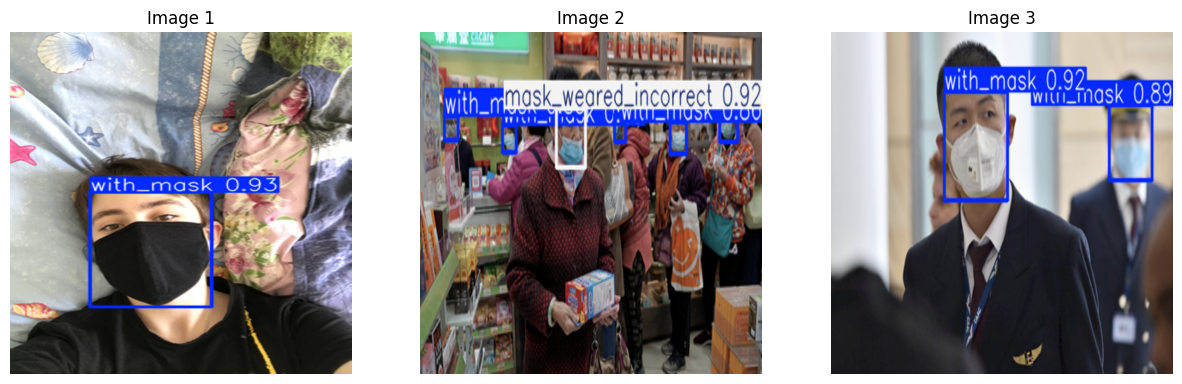

In [38]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the directory containing the predicted images
predicted_images_dir = '/kaggle/working/runs/detect/predict'  # Adjust the path accordingly

# List all image files in the directory
image_files = [f for f in os.listdir(predicted_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Randomly choose 3 images
random_images = random.sample(image_files, 3)

# Set the desired size for resizing (e.g., 1024x1024 pixels)
resize_size = (1024, 1024)

# Plot and resize the chosen images
plt.figure(figsize=(15, 15))
for i, image_file in enumerate(random_images):
    # Load the image
    img_path = os.path.join(predicted_images_dir, image_file)
    img = Image.open(img_path)
    
    # Resize the image
    img_resized = img.resize(resize_size)
    
    # Display the image
    plt.subplot(1, 3, i+1)  # Display 3 images side by side
    plt.imshow(img_resized)
    plt.title(f"Image {i+1}")
    plt.axis('off')

plt.show()
